# Abrupt change detection

### **Excercise** 

This excercise focusses on the detection of abrupt changes in satellite time series. Specifically, we'll focus on detecting forest fires in Peloponnese, Greece. In the summer of 2007, Peloponnese was hit by  large scale forest fires, where the most destructive ones took place towards the end of August. The forest fires of 2007 in Greece destroyed about 4% of the total forested area of the country and had a large financial and ecological cost.



<img src="./auxiliary/1610_hi-res.jpg" alt="fire" style="height:400px;"/> <img src="./auxiliary/fire.jpg" alt="fires" style="height:400px;"/>

*Forest fires in Greece. Left: affected area on August 28, 2007 
(source: European Commissian; https://ec.europa.eu/jrc/en/news/european-forest-fire-information-system-latest-figures-forest-fires-greece-7485). Right: fires threatening homes in Greece (Source: BBC; https://www.bbc.com/news/world-europe-33564237)*

In this excercise we'll explore the capacity of change detection algorithms to detect the forest loss due to fire. We will apply a change detection alogrithm on NDVI time series over areas that have been burnt.



### **BFAST** 

We'll illustrate the detection of abrupt changes in satellite time series using the Breaks For Additive Season and Trend (BFAST) algorithm. BFAST integrates the decomposition of time series into trend, season, and remainder components with methods for detecting and characterizing change within time series. The algorithm iteratively estimates the time and number of abrupt changes within time series, and characterizes change by its magnitude and direction.

<img src="./aux/seasonalbreak_TreeMort.jpg" alt="seasonalbreak_TreeMort" style="width:800px;"/>


You can find more information about BFAST in:

- Verbesselt, J., Hyndman, R., Newnham, G., & Culvenor, D. (2010). Detecting trend and seasonal changes in satellite image time series. Remote Sensing of Environment, 114, 106-115. DOI: 10.1016/j.rse.2009.08.014.

- Verbesselt, J., Hyndman, R., Zeileis, A., & Culvenor, D. (2010). Phenological change detection while accounting for abrupt and gradual trends in satellite image time series. Remote Sensing of Environment, 114, 2970-2980. DOI: 10.1016/j.rse.2010.08.003. 

Since the origitnal algorithm was written in R, we will build upon a python version implemented by Dmitry Serykh (https://github.com/mortvest/bfast-py).


In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('./scripts/BFAST')
sys.path.append('./scripts/BFAST/src')
from plots import plot
from bfast import BFAST


### **Import data**

First, we need to import our data. We will be using 10-daily, 1km resolution NDVI data acquired from SPOT/VEGETATION and PROBA-V between January 1999 and September 2019 that have been made available in the data folder.

In [15]:
data_file = pathlib.Path('./data/D_change_detection/ts_fire.csv')
dat_fire = pd.read_csv(data_file)
dat_fire

,time,0
0,1999-01-01,194
1,1999-01-11,198
2,1999-01-21,180
3,1999-02-01,181
4,1999-02-11,173
...,...,...
751,2019-11-11,204
752,2019-11-21,255
753,2019-12-01,183
754,2019-12-11,211


### **Missing values**

Missing values are stored using a value of 255 and data have been scaled with an offset and scaling factor. We will first set the missing observations as no data and unscale the values. Missing values will subsequently be filled using a linear interpolation so we get a complete time series. 

When we plot a time series in one of the fire patches, we can observe that the NDVI shows a sudden drop in 2007, which is at the time of the fire. After the abrupt change in NDVI in 2007, the NDVI seems to gradually recover.

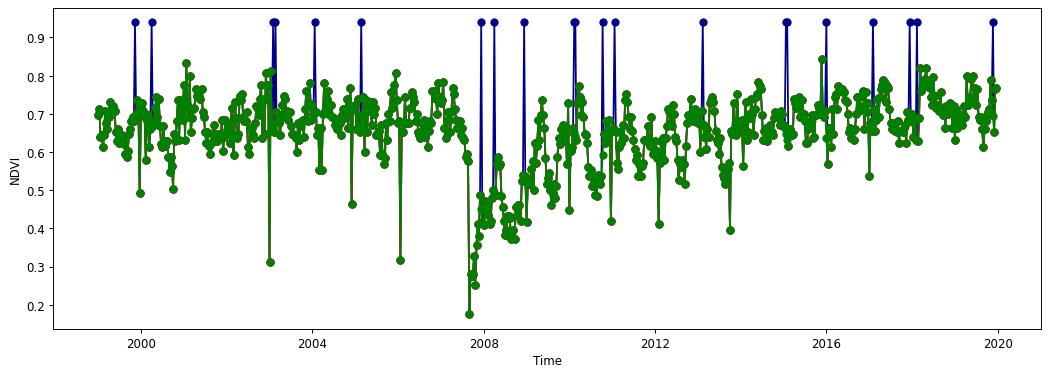

In [23]:
# data after scaling but without masking missing values and interpolation
dat_pre = ((dat_fire.copy()['0']*0.0040000002)-0.079999998)

# mask and scale the data
dat_masked = dat_fire.copy()
dat_masked.loc[dat_masked['0'] == 255,'0'] = np.NaN
dat_masked['0'] = ((dat_masked['0']*0.0040000002)-0.079999998)

# interpolate missing values
dat = dat_masked.copy().interpolate(method='linear')

x= dat_fire['time'].values
x = pd.DatetimeIndex([pd.Timestamp(d) for d in x])

# let's plot
fig = plt.figure(figsize=(15, 5), dpi=85)
plt.plot(x,dat_pre,'o-', color = 'darkblue')
plt.plot(x,dat_masked['0'],'o-', color = 'red')
plt.plot(x,dat['0'],'o-', color='green')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.show()

### **Change the cadence of the time series**

Since monthly observations are sufficient to perform the change detection and will require less computation time, we will subsequently change the cadence of the time series from ten-daily to monthly observations. We'll use the mean value per month to change the cadence.

                   0
time                
1999-01-31  0.682667
1999-02-28  0.633333
1999-03-31  0.681333
1999-04-30  0.710667
1999-05-31  0.713333
...              ...
2019-08-31  0.678667
2019-09-30  0.650667
2019-10-31  0.704000
2019-11-30  0.739333
2019-12-31  0.728000

[252 rows x 1 columns]


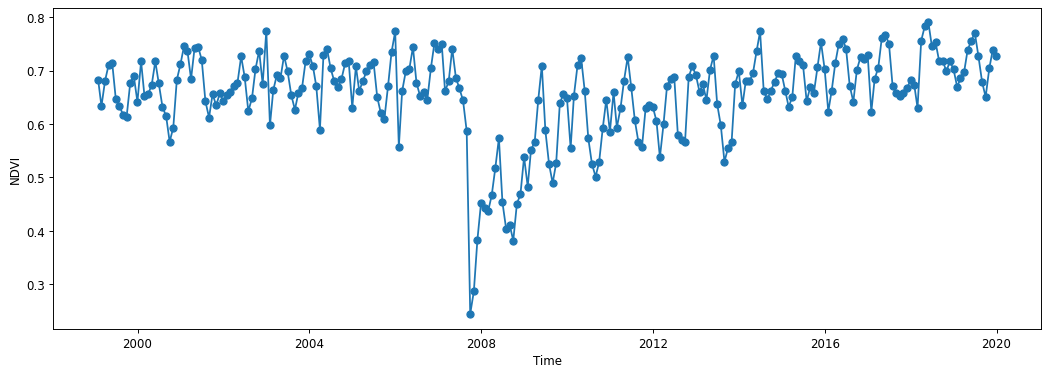

In [24]:
ds_int = dat.copy()
ds_int['time'] = x
ds_int = ds_int.resample('1M', on='time').mean()

fig = plt.figure(figsize=(15, 5), dpi=85)
x = ds_int.index
y = ds_int
plt.plot(x,y,'o-')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.show()

### **Decomposition using STL**

Before applying a break detection algorithm, let's first check how STL would decompose this time series. Both the STL trend and seasonal component show a change around the timing of the fire. The trend component shows a decrease in NDVI around 2007, followed by a recovery period. The drop in NDVI around the timing of the fire is however not abrupt but shows a gradual transition. The seasonal component shows a change in intra-annual variability around the fire: the intra-annual variability increases after the fire and seems to return to the pre-fire conditions towards the end of the time series.  

<Figure size 765x595 with 0 Axes>

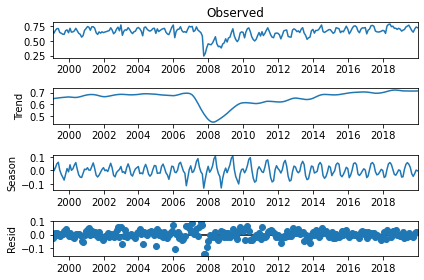

In [25]:
from statsmodels.tsa.seasonal import STL
stl = STL(y, period=12)
res = stl.fit()
fig = plt.figure(figsize=(9, 7), dpi=85)
fig = res.plot()

### **BFAST**

Let's now apply BFAST! As mentioned at the beginning of the notebook, BFAST decomposes a time series into a trend, seasonality and remainder component while checking for significant breaks. The algorithm requires several input parameters: 
- `y`: the response values to be analyzed
- `x`: the time stamps associated with the observations. These should be expressed as a float. For example, monthly observations between 1999 and 2000 would be expressed as 1999, 1999.08, 1999.17, ..., 1999.83, 1999.92.
- `frequency`: number of observations per year
- `h`: minimal segment size between potentially detected breaks in the trend model given as fraction relative to the sample size (i.e. the minimal number of observations in each segment divided by the total length of the timeseries).
- `season`: the seasonal model used to fit the seasonal component and detect seasonal breaks (i.e. significant phenological change). There are three options: "dummy", "harmonic", or "none". "none" indicates that no seasonal model will be fitted (i.e. St = 0 ). If there is no seasonal cycle (e.g. frequency of the time series is 1) "none" can be selected to avoid fitting a seasonal model.
- `level`: threshold value for the sctest.efp test; if a length 2 vector is passed, the first value is used for the trend, the second for the seasonality
- `max_iter`: maximum amount of iterations allowed for estimation of breakpoints in seasonal and trend component.
- `verbosity`: verbosity of the function

We'll first convert the dates to the format required by BFAST (using the `r_style_interval` function) and subsequently apply BFAST and a single time series and plot the result.

Using the standard BFAST parameters, change is only detected in the trend component. In contrast to STL, BFAST characterizes the event as an abrupt change. The trend component shows a sudden drop in NDVI around the timing of the fire and is followed by a recovery period. 

Plotting test


<Figure size 765x595 with 0 Axes>

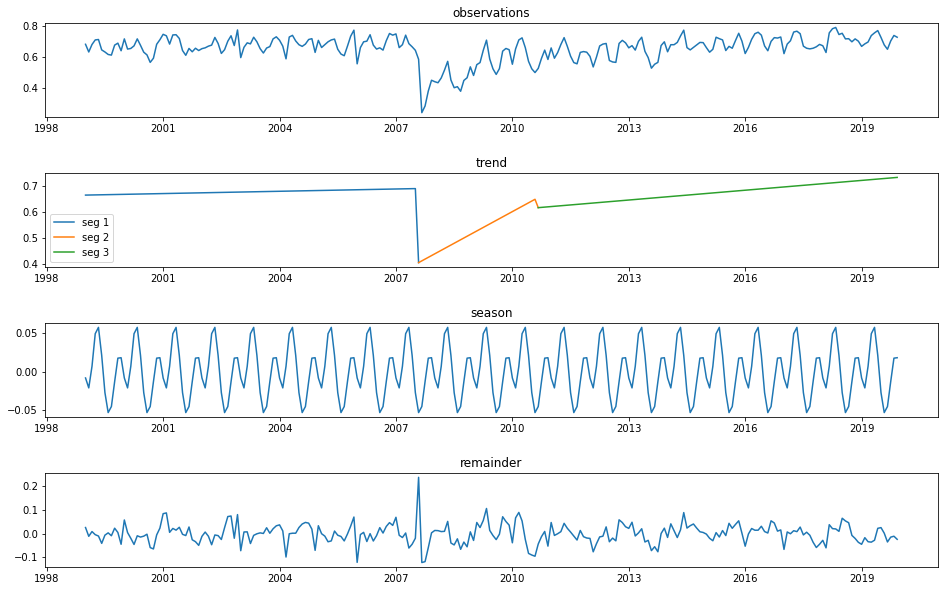

In [26]:
# function to convert a date to the BFAST date inputs
def r_style_interval(from_tuple, end_tuple, frequency):
    """
    create time interval using R-style double-tuple notation
    """
    from_year, from_seg = from_tuple
    end_year, end_seg = end_tuple
    n = (end_year - from_year + 1) * frequency
    full_range = np.linspace(from_year, end_year + 1, num=n, endpoint=False)
    real_range = full_range[(from_seg - 1):n - (frequency - end_seg)]
    return real_range

# let's get the time series observations and associated time stamps
y= np.squeeze(y.values)
x = r_style_interval((1999,1), (2019,12), 12).reshape(y.shape[0], 1)

# Apply BFAST and plot the result (the 'plot' function )
fig = plt.figure(figsize=(9, 7), dpi=85)
dat = plot('test',y, x, 12, season='harmonic', level=0.05, h=0.15, max_iter=10, nan_clr="crimson")
plt.show()

Sometimes you don't want to plot but get the timing of the breaks or the time series components in order to perform further analyses. You can achieve this by calling the `BFAST` function directly and extracting the desired information from the BFAST object. `trend_breakpoints` and `season_breakpoints` provide the timing of the trend and seasonal breakpoints, while the `trend`, `season`, and `remainder` components provide the trend, season, and remainder components, respectively.

In [27]:
dat = BFAST(y, x, 12, season='harmonic', level=0.05, h=0.15, max_iter=10, verbosity=0).output

print(f'breakpoints trend: {dat.trend_breakpoints}')
print(f'trend: {dat.trend}')
print(f'season: {dat.season}')
print(f'breakpoints season: {dat.season_breakpoints}')
print(f'remainder: {dat.remainder}')


breakpoints trend: [103 140]
trend: [0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67
 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.68 0.68 0.68 0.68 0.68 0.68 0.68
 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68
 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.68 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69
 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.69 0.4  0.41 0.42 0.42 0.43 0.44 0.44 0.45 0.46 0.46 0.47 0.48
 0.49 0.49 0.5  0.51 0.51 0.52 0.53 0.53 0.54 0.55 0.55 0.56 0.57 0.57 0.58 0.59 0.59 0.6  0.61 0.62 0.62 0.63 0.64
 0.64 0.65 0.62 0.62 0.62 0.62 0.62 0.62 0.62 0.62 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.64 0.64 0.64
 0.64 0.64 0.64 0.64 0.64 0.64 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.66 0.66 0.66 0.66 0.66 0.66 0.66
 0.66 0.66 0.67 0.67 0.67 0.67 0.67 

### **Now it's your turn!**

**Question**: load the time series in ./data/D_change_detection/ts_fire2.csv and detect the breaks in the time series.